# Classification of genre - logistic regression and hierarchical model

Importing required libraries:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Loading data:

In [2]:
#### pop = 1 ####
pop1 = pd.read_csv("SpotifyAudioFeatures2017.csv")
pop2 = pd.read_csv("SpotifyAudioFeatures2018.csv")
pop3 = pd.read_csv("SpotifyAudioFeatures2019.csv")
df_pop = pd.concat([pop1, pop2,pop3])
df_pop["genre"] = [1]*len(df_pop)

#### metal = 2 ####
met1 = pd.read_csv("SpotifyAudioFeatures2017metal.csv")
met2 = pd.read_csv("SpotifyAudioFeatures2018metal.csv")
met3 = pd.read_csv("SpotifyAudioFeatures2019metal.csv")
#df_met = pd.concat([met1, met2, met3])
df_met = pd.read_csv("SpotifyAudioFeatures201720182019metal.csv")
df_met["genre"] = [2]*len(df_met)

#### classical = 3 ####
df_clas = pd.read_csv("SpotifyAudioFeaturesclassical.csv")
df_clas["genre"] = [3]*len(df_clas)

#### rap = 4 ####
rap1 = pd.read_csv("SpotifyAudioFeatures2017rap.csv")
rap2 = pd.read_csv("SpotifyAudioFeatures2018rap.csv")
rap3 = pd.read_csv("SpotifyAudioFeatures2019rap.csv")
#df_rap = pd.concat([rap1, rap2, rap3])
df_rap = pd.read_csv("SpotifyAudioFeatures201720182019rap.csv")
df_rap["genre"] = [4]*len(df_rap)

df = pd.concat([df_rap,df_met,df_clas,df_pop])
#df.to_csv("genredata.csv")

In [3]:
print("Shape of pop (1): ", df_pop.shape)
print("Shape of metal (2): ", df_met.shape)
print("Shape of classical (3): ", df_clas.shape) 
print("Shape of rap (4): ",df_rap.shape)

Shape of pop (1):  (6018, 19)
Shape of metal (2):  (4481, 19)
Shape of classical (3):  (5040, 19)
Shape of rap (4):  (2786, 19)


In [5]:
# load csv
df_tracks = pd.read_csv("genredata.csv")
df_tracks = df
#df_tracks = df_tracks.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
df_tracks = df_tracks.dropna(axis = 0)
df_tracks.head()

Preprocessing data:

In [18]:
#df_tracks = shuffle(df_tracks)
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

# doing the same grouping as before to verify the solution
grouped_after_dropping = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped_after_dropping[grouped_after_dropping > 1].count()

df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()
df = df_tracks
#df = shuffle(df)
df.shape
#ind = df["Unnamed: 0"]
#df.to_csv("genredata.csv")

(16764, 19)

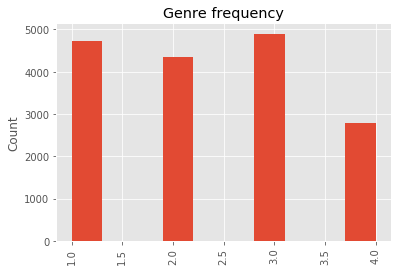

In [10]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(rotation=90)
plt.show()

In [28]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.drop(['artist_name','track_name','track_id'],axis = 1)
mat = mat.values
X = mat[:,2:-1].astype("float")
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,0].astype("int")
print(ind.shape)

(16764, 13)
(16764,)
(16764,)


In [29]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [30]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 11064
num test: 5700


In [31]:
ix_train

array([ 1937, 10597,  2873, ...,  6771, 14701,  3219])

Our baseline logistic regression model from sklearn:

In [32]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("Predictions:", y_hat)
print("True values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Predictions: [2 1 2 ... 3 1 3]
True values: [2 4 2 ... 3 1 3]
Accuracy: 0.7924561403508772


## Hierarchical logistic regression in STAN

We will now implement a hierarchical logistic regression. The motivation is actually quite simple. Our dataset consists of multiple observations from various individuals. However, when we build our original logistic regression in STAN, our specification assumes that all individuals share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all individuals are equally biased towards a given mode (e.g. car). This is obviously a very strong assumption, right? We should allow different individuals to have different biases (alpha). (We could also consider different coefficients per individual, but for the sake of simplicy, we will just focus on the bias parameters)

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global intercept mean $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global intercept variance $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. Draw coefficients $\boldsymbol\beta_c \sim \mathcal{N}(\textbf{0},10 \, \textbf{I})$ (this the same as before...)
    6. For each individual $i \in \{1,\dots,I\}$
        4. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the individual identifier for person $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

Notice that now, instead of a single intercept per class $\alpha_c$ for all individual, we now have a vector of intercepts $\boldsymbol\alpha_c$ for each class $c$: one intercept parameter per individual! However, all these intercept share a global (population-level) prior.

Lets try to implement this in STAN. Can you do it? :-) 

In [34]:
# define Stan model
model_definition = """
data {
    int<lower=0> N;
    int<lower=1> D;
    int<lower=1> C;
    int<lower=1> I;
    int ind[N];
    matrix[N,D] X;
    int<lower=0,upper = C> y[N];
}
parameters {
    matrix[C,D] beta;
    matrix[I,C] alpha; // i individer og c classes, intercept/bias for hver class, 4 intercepts for hver
    
    vector[C] mu_prior;
    vector<lower=0>[C] sigma_prior;
    
}

model {
    for(c in 1:C){
        mu_prior[c] ~ normal(0,1);
        sigma_prior[c] ~ normal(0,1);
        beta[c] ~ normal(0,1);
        
        for(i in 1:I){
            alpha[i,c] ~ normal(mu_prior[c],sigma_prior[c]);
        }
    }
    for(n in 1:N){
        y[n] ~ categorical(softmax(alpha[ind[n],:]' + beta*X[n]'));
    }
}

"""

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [35]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N = %d, D = %d, C = %d, I = %d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N = 11064, D = 16, C = 4, I = 100


In [36]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47fb036e992c954f28293ae82a359042 NOW.
C:\Users\clara\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\clara\AppData\Local\Temp\tmpkqxi5i8_\stanfit4anon_model_47fb036e992c954f28293ae82a359042_1659035022966619179.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
C:\Users\clara\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


RuntimeError: Exception: matrix[uni,multi] indexing, row: accessing element out of range. index 0 out of range; expecting index to be between 1 and 100  (in 'unknown file name' at line 31)


Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

In [37]:
pystan_utils.vb_plot_variables(fit, "mu_prior") #mu_prior
# Hyper-priors for each class for all the 

NameError: name 'fit' is not defined

In [ ]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [ ]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per-individual, and adapt the code for making predictions accordingly. Make sure that you understand the code below. As always, if something is not 100% clear, ask! :-)

In [ ]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Now, that is a signficant improvement, right? We improved the accuracy of our model from 67.9% to about 78.4%! (Hopefully you were able to obtain a similar or even better result :-)

Did you see how your prior knowledge about the problem can make a substantial difference when building a model for it? This is how things are done in the model-based machine learning approach!

Given the posterior distributions inferred by STAN, we can even analyse the biases of different individuals identified by our model:

In [ ]:
for i in range(I):
    print(i, alpha[:,i])

Perhaps a histogram allows for a better global analysis:

In [ ]:
# histogram of biases towards mode 4 (car)
plt.hist(alpha[3,:])
plt.title("Biases towards mode 4")
plt.xlabel("alpha[4]")
plt.show()

We can observe that, for most individuals the biases is around 0. However, we can also see that a few individuals really love their cars!

Reflection exercise: can you think of ways in which you could use this model to try to identify policies (e.g. price changes or making terminals more efficient) that would allow to shift people's travel mode choices away from the car (e.g. towards public transport)?